### Libraries:
In principle, it is necessary to import the libraries that will be used to raise the lookup tables.

In [16]:
# Required Libraries
import numpy as np
import scipy.optimize as sci
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar as root
import pandas as pd

### Input data user:
It is necessary to declare the parameters associated with the wind turbine.

In [17]:
# Mech data
R = 37.5 # m
N = 111.5

# Power coefficient constants
C = [0.22,116,0.4,0,0,5,12.5,0.08,0.035]

# Nominal power
P_nom = 2 # MW

# Air density
par = 1.225 #kg/m³

# Turbina data
Nmin_tur = 13 # rpm
Nnom_tur = 18 # rpm

# Speed wind data 
Vw_min =  4 # m/s
Vw_nom = 12 # m/s
Vw_max = 25 # m/s

# Number of steps per region
nstep = 15

### Raising the maximum power coefficient:
To determine the minimum and maximum turbine speeds, that is, the references of regions 1 and 3, it is necessary to find the optimal value of the power coefficient.

\begin{gather}
	C_p(\lambda, \beta) = C_1 \left(\frac{C_2}{\alpha(\lambda, \beta)} - C_3\,\beta - C_4\,\beta ^{C_5} - C_6 \right) e^{-\frac{C_7}{\alpha(\lambda, \beta)}}
	\label{eq:G3_powerCoef1}
\end{gather}

\begin{gather}
	\frac{1}{\alpha(\lambda, \beta)} =  \frac{1}{\lambda - C_8\, \beta} - \frac{C_9}{\beta^3 + 1}
	\label{eq:G3_powerCoef2}
\end{gather}

In [18]:
# Raising the maximum power coefficient 
def CP(x):
  alpha = (1 / (x[0]+ x[1] * C[7]) - C[8] / (x[1] ** 3 + 1))**-1
  cp = C[0] * (C[1] / alpha - C[2] * x[1] - C[3] * x[1] ** C[4] - C[5]) * np.exp(-C[6] / alpha)
  return -cp

# Performing the optimization
opt = sci.minimize(CP,[1,0], bounds = [[0, 30],[0, 30]])

LBD_opt = opt.x[0]  # Lambda optimum
Beta_opt = opt.x[1] # Beta optimum
CP_opt = -opt.fun   # CP optimum

print(f'Convergent -> {opt.success}')
print(f'Maximum power coefficient -> {-opt.fun}')
print(f'Lambda optimum -> {opt.x[0]}')
print(f'Beta optimum -> {opt.x[1]}')

Convergent -> True
Maximum power coefficient -> 0.4382090105978689
Lambda optimum -> 6.324969981694354
Beta optimum -> 0.0


### Region 1 and 3: Following the minimum and nominal speed
For the investigation of region 1, it is necessary to define the minimum speed reference together with the wind speed that results in this minimum speed.

\begin{align}
    V_w^{\omega_{min}} = n_{tur}^{min} \left(\frac{2\,\pi}{60}\right)\,\frac{R}{\lambda_{opt}}
\end{align}

For the investigation of region 3, it is necessary to define the nominal speed reference together with the wind speed that results in this nominal speed.

\begin{align}
    V_w^{\omega_{nom}} = n_{tur}^{nom} \left(\frac{2\,\pi}{60}\right)\,\frac{R}{\lambda_{opt}}
\end{align}

The premise for the pitch angle is to remain inactive during this region.

In [19]:
# Region 1 - minimum speed
Wmin_br = Nmin_tur*(2*np.pi/60)
Vw_wmin = Wmin_br*(R/LBD_opt)

Wmin = Wmin_br*N
print(f'Minimum reference speed -> {Wmin} rad/s')
print(f'Terminal velocity of region 1 -> {Vw_wmin} m/s')

# Region 3 - nominal
Wnom_br = Nnom_tur*(2*np.pi/60)
Vw_wnom = Wnom_br*(R/LBD_opt)

Wnom = Wnom_br*N
print(f'Nominal reference speed -> {Wnom} rad/s')
print(f'Start velocity of region 3 -> {Vw_wnom} m/s')

Minimum reference speed -> 151.79128504594684 rad/s
Terminal velocity of region 1 -> 8.071323779968116 m/s
Nominal reference speed -> 210.17254852515717 rad/s
Start velocity of region 3 -> 11.175679079955854 m/s


### Region 2: Maximum power point tracking
The premise of the present region is based on calculating the value associated with the pitch angle and the specific speed of the turbine so that this results in the maximum power coefficient for any given wind speed.

In [20]:
# Region 2 - Maximization of the power coefficient
def F(Vw):
  def f(myVetf):
    alpha = (1 / ((R*myVetf[0]/Vw/N) + myVetf[1] * C[7]) - C[8] / (myVetf[1] ** 3 + 1))**-1
    Cp = C[0] * (C[1] / alpha - C[2] * myVetf[1] - C[3] * myVetf[1] ** C[4] - C[5]) * np.exp(-C[6] / alpha)
    return -Cp
  return f

# Declaration of vectors
Vw_vet = np.linspace(Vw_wmin,Vw_wnom,nstep)
Wrm_vetR2 = np.zeros_like(Vw_vet)
beta_vetR2 = np.zeros_like(Vw_vet)
v0 = [100, 1]

# Solver call
for k,v in enumerate(Vw_vet):
  sol = sci.minimize(F(v), v0, bounds = [[100, 300],[0, 30]]) 
  Wrm_vetR2[k] = sol.x[0]
  beta_vetR2[k] = sol.x[1]

### Region 4: Limiting turbine power
To investigate region 4, it is necessary to define the values for the pitch angle so that the power does not exceed the nominal defined for the wind turbine.

In [21]:
# Turbine power functions:
def Ptur(Vw, Wtur, beta):
  LBD = R * Wtur/Vw
  Ptur = 1 / 2 * par * np.pi*R**2 *-CP([LBD, beta])* Vw **3
  return Ptur

# Fitness function
def F(Vw):
  def f(beta):
    Ptur_nom = Ptur(Vw_nom, Wnom_br, 0)
    return Ptur_nom - Ptur(Vw,Wnom_br,beta)
  return f

# Declaration of vectors
Vw_vet = np.linspace(Vw_nom,Vw_max,nstep)
beta_vet = np.zeros_like(Vw_vet)
v0 = 0

# Solver call
for k,v in enumerate(Vw_vet):
  sol = root(F(v), bracket=(0,35), method='bisect')
  beta_vet[k] = sol.root
  v0 = beta_vet[k]

### Creating a view table:
The lookup table will be created in this section and relates the reference values for the speed and pitch angle with the wind speeds that the present wind turbine can subject.

In [31]:
vetor_Wrm = np.zeros(int(4*nstep))
vetor_Bet = np.zeros(int(4*nstep))

Wrm_R1 = Wmin*np.ones(int(nstep))
Wrm_R2 = Wrm_vetR2
Wrm_R3 = Wnom*np.ones(int(nstep))
Wrm_R4 = Wrm_R3
vetor_Wrm = np.concatenate((Wrm_R1,Wrm_R2,Wrm_R3,Wrm_R4))

Bet_R1 = np.zeros(int(nstep))
Bet_R2 = beta_vetR2
Bet_R3 = np.zeros(int(nstep))
Bet_R4 = beta_vet
vetor_Bet = np.concatenate((Bet_R1,Bet_R2,Bet_R3,Bet_R4))

Vw_R1 = np.linspace(Vw_min, Vw_wmin, int(nstep))
Vw_R2 = np.linspace(Vw_wmin+1e-3, Vw_wnom, int(nstep))
Vw_R3 = np.linspace(Vw_wnom+1e-3, Vw_nom, int(nstep))
Vw_R4 = np.linspace(Vw_nom +1e-3, Vw_max, int(nstep))
vetor_Vw = np.concatenate((Vw_R1,Vw_R2,Vw_R3,Vw_R4))

lTable = pd.DataFrame({'Vw': vetor_Vw,
                       'Wrm': vetor_Wrm,
                       'Beta': vetor_Bet})

# lTable
print(lTable.to_latex(index=False))  

\begin{tabular}{rrr}
\toprule
       Vw &        Wrm &      Beta \\
\midrule
 4.000000 & 151.791285 &  0.000000 \\
 4.290809 & 151.791285 &  0.000000 \\
 4.581618 & 151.791285 &  0.000000 \\
 4.872427 & 151.791285 &  0.000000 \\
 5.163235 & 151.791285 &  0.000000 \\
 5.454044 & 151.791285 &  0.000000 \\
 5.744853 & 151.791285 &  0.000000 \\
 6.035662 & 151.791285 &  0.000000 \\
 6.326471 & 151.791285 &  0.000000 \\
 6.617280 & 151.791285 &  0.000000 \\
 6.908088 & 151.791285 &  0.000000 \\
 7.198897 & 151.791285 &  0.000000 \\
 7.489706 & 151.791285 &  0.000000 \\
 7.780515 & 151.791285 &  0.000000 \\
 8.071324 & 151.791285 &  0.000000 \\
 8.072324 & 151.784341 &  0.000000 \\
 8.293992 & 155.947422 &  0.000000 \\
 8.515660 & 160.096032 &  0.000000 \\
 8.737328 & 164.385673 &  0.000000 \\
 8.958997 & 168.450270 &  0.000000 \\
 9.180665 & 172.636941 &  0.000000 \\
 9.402333 & 176.766834 &  0.000000 \\
 9.624001 & 180.850979 &  0.000000 \\
 9.845670 & 185.176574 &  0.000000 \\
10.067338 &

/tmp/ipykernel_7568/2777141785.py:27: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(lTable.to_latex(index=False))


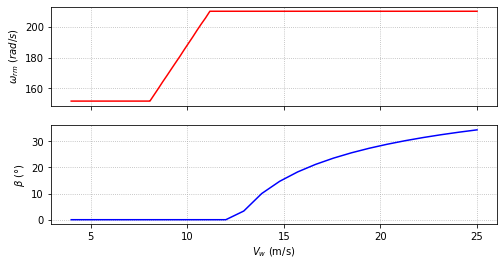

In [23]:
# Declaração da Figura:
fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True)
fig.set_size_inches(8, 4)

# Plots:
ax1.plot(vetor_Vw, vetor_Wrm, color='r')
ax2.plot(vetor_Vw, vetor_Bet, color='b')

ax1.set(xlabel='',    ylabel='$\omega_{rm}$ $(rad/s)$')
ax2.set(xlabel='$V_w$ (m/s)',    ylabel='$\\beta$ $(°)$')

ax1.grid(True, linestyle='dotted')
ax2.grid(True, linestyle='dotted')

plt.show()